# 線形回帰

## 概要

線形関数とガウシアンノイズから観測値を生成し、元の線形関数を予測する線形回帰のタスクである。  
回帰は単純なニューラルネットワークを用いて行う。ネットワークの重みは最急降下法で最適化する。

## 以下訳文

最初の項では、

- 非常に単純なニューラルネットワーク
- 目的関数(ターゲット関数とコスト関数)の考え方
- 勾配降下法(最急降下法)の最適化

について説明する。この項では、1入力/1出力の線形回帰モデルを扱う。ネットワークは入力値$x$を受け、重み$w$によって値を計算し、出力値$y$を生成する。  
式は $y = x*w$ となる。
$y$は、ターゲット値$t$の最適解である。

<img src="SimpleANN01.png">

一般的に、ニューラルネットワークといえば、複数のレイヤ、非線形活性化関数、そして各ノードのバイアスが存在する。  
このチュートリアルでは、重みが1つ($w$とする)のレイヤを1つのみ持ち、出力の活性化関数やバイアスは考えない。単純な線形回帰において、バイアスは$y$切片、重みwは回帰直線の傾きである。線形回帰では、これらのパラメータは一般的に最小二乗法で計算する。  
  
このチュートリアルでは、ターゲット$t$を求めるモデル$y$は、最小二乗誤差の関数で求める。この式は $||t-y||^2$ で定義される。ニューラルネットワークの訓練によってコストの最小化を行う。手法として最急降下法を用いる。

In [1]:
# Python imports
import numpy  # Matrix and vector computation package
import matplotlib.pyplot as plt  # Plotting library
# Allow matplotlib to plot inside this notebook
%matplotlib inline
# Set the seed of the numpy random number generator so that the tutorial is reproducable
numpy.random.seed(seed=1)

## ターゲット関数の定義

ターゲット値$t$は、ターゲット関数fによって算出される値に、$N(0, 0.2)$のガウシアンノイズを加算したものである。ここで、$N$は平均$0$、分散$0.2$の正規分布である。
$f$を$f(x) = 2x$ (傾き$2$、切片$0$)で定義するとき、$t$は次のようになる。  
$t = f(x) + N(0, 0.2)$  
$20$個の値から成る入力値群$x$を定義する。$x$の構成値はそれぞれ範囲0～1の一様乱数であり、$t$の計算式は上記の通りである。入力値群$x$に対するターゲット値$t$を平面上にプロットし、また元の$f(x)$のグラシアンノイズを加算しない直線を引く。入力値群$x$の各構成値を$x_i$、ターゲット値$t$の各構成値を$t_i$とする。

In [2]:
# Define the vector of input samples as x, with 20 values sampled from a uniform distribution
# between 0 and 1
x = numpy.random.uniform(0, 1, 20)

# Generate the target values t from x with small gaussian noise so the estimation won't
# be perfect.
# Define a function f that represents the line that generates t without noise
def f(x): return x * 2

# Create the targets t with some gaussian noise
noise_variance = 0.2  # Variance of the gaussian noise
# Gaussian noise error for each sample in x
noise = numpy.random.randn(x.shape[0]) * noise_variance
# Create targets t
t = f(x) + noise

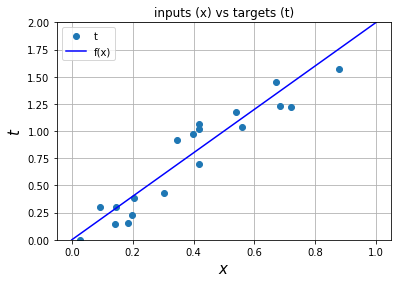

In [3]:
# Plot the target t versus the input x
plt.plot(x, t, 'o', label='t')
# Plot the initial line
plt.plot([0, 1], [f(0), f(1)], 'b-', label='f(x)')
plt.xlabel('$x$', fontsize=15)
plt.ylabel('$t$', fontsize=15)
plt.ylim([0,2])
plt.title('inputs (x) vs targets (t)')
plt.grid()
plt.legend(loc=2)
plt.show()

## コスト関数の定義

モデル$y=x*w$において、重み$w$を二乗誤差法によって最小化する。  
二乗誤差は$\xi = \sum_{i=1}^{N} \Vert t_i - y_i \Vert ^2$によって定義される。$N$はサンプル数である(今回は$N=20$)。  
このとき、コスト関数が最小となる重み$w$は、$\underset{w}{\text{argmin}} \sum_{i=1}^{N} \Vert t_i - y_i \Vert^2$と定義される。

コスト関数の重み$w$を下に示す。$w=2$のとき、コストは最小になり(パラボラ形の極小値)、これは先に定義した$f(x)$の傾きに一致する。  

ニューラルネットワークモデルをnn(x, w)、コスト関数をcost(y, t)とする。

In [4]:
# Define the neural network function y = x * w
def nn(x, w): return x * w

# Define the cost function
def cost(y, t): return ((t - y)**2).sum()

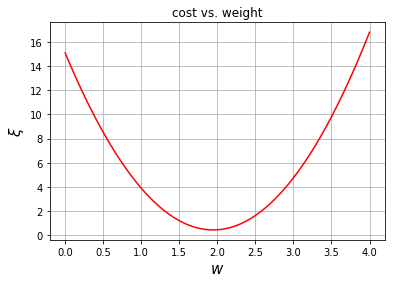

In [5]:
# Plot the cost vs the given weight w

# Define a vector of weights for which we want to plot the cost
ws = numpy.linspace(0, 4, num=100)  # weight values
cost_ws = numpy.vectorize(lambda w: cost(nn(x, w) , t))(ws)  # cost for each weight in ws

# Plot
plt.plot(ws, cost_ws, 'r-')
plt.xlabel('$w$', fontsize=15)
plt.ylabel('$\\xi$', fontsize=15)
plt.title('cost vs. weight')
plt.grid()
plt.show()

## コスト関数の最適化

この例のような単純なコスト関数であれば、目視で最適解を求めることもできる。ただ多くの場合、誤差は複雑で高次元である。それが最小誤差を用いる理由である。  

### 最急降下法

最急降下法は、最適化アルゴリズムの一つで、ニューラルネットワークの訓練によく使われる。
最急降下アルゴリズムは、コスト関数$\xi$の特定位置における導関数で、何度も反復して(イテレーション)重み$w$更新していく。 $k$回目のイテレーションにおける重み$w$を$w(k)$と表すとき、$k+1$回目のイテレーションで更新される重みの値は次のように表される。
$$w(k+1) = w(k) - \Delta w(k)$$

また、勾配$\Delta w$は次のように表される。  

$$\Delta w = \mu \frac{\partial \xi}{\partial w}$$

ここで$\mu$は学習率であり、${\partial \xi}/{\partial w}$は重み$w$に関する関数$\xi$の勾配である。勾配の各サンプル$i$について、連鎖律を用いると、

$$\frac{\partial \xi_i}{\partial w} = \frac{\partial y_i}{\partial w} \frac{\partial \xi_i}{\partial y_i}$$

ここで$\xi_i$は二乗誤差のコストであり、${\partial \xi_i}/{\partial y_i}$は次のように表せる。

$$\frac{\partial \xi_i}{\partial y_i} = \frac{\partial (t_i - y_i)^2}{\partial y_i} = - 2 (t_i - y_i) = 2 (y_i - t_i)$$

$y_i = x_i * w$のとき、${\partial y_i}/{\partial w}$は、

$$\frac{\partial y_i}{\partial w} = \frac{\partial (x_i * w)}{\partial w} = x_i $$

と表せるので、サンプル$i$に対する$\Delta w$は、

$$\Delta w = \mu * \frac{\partial \xi_i}{\partial w} = \mu * 2 x_i (y_i - t_i)$$

バッチ学習においては、この和をとって、

$$\Delta w = \mu * 2 * \sum_{i=1}^{N} x_i (y_i - t_i)$$


最急降下アルゴリズムにおいて、$\Delta w$を収束させるために必要な初期値を設定する必要がある。学習率は別にチューニングする必要があり、ニューラルネットワークにおいて「ハイパーパラメータ」と呼ばれる。

勾配${\partial \xi}/{\partial w}$の関数を`gradient(w, x, t)`として実装する。$\Delta w$は`delta_w(w_k, x, t, learning_rate)`によって計算する。4イテレーションを回し、イテレーションごとの結果を出力する。

In [6]:
# Define the neural network function y = x * w
def nn(x, w): return x * w

# Define the cost function
def cost(y, t): return ((t - y)**2).sum()

In [7]:
# define the gradient function. Remember that y = nn(x, w) = x * w
def gradient(w, x, t): 
    return 2 * x * (nn(x, w) - t)

# define the update function delta w
def delta_w(w_k, x, t, learning_rate):
    return learning_rate * gradient(w_k, x, t).sum()

# Set the initial weight parameter
w = 0.1
# Set the learning rate
learning_rate = 0.1

# Start performing the gradient descent updates, and print the weights and cost:
nb_of_iterations = 4  # number of gradient descent updates
w_cost = [(w, cost(nn(x, w), t))] # List to store the weight,costs values
for i in range(nb_of_iterations):
    dw = delta_w(w, x, t, learning_rate)  # Get the delta w update
    w = w - dw  # Update the current weight parameter
    w_cost.append((w, cost(nn(x, w), t)))  # Add weight,cost to list

# Print the final w, and cost
for i in range(0, len(w_cost)):
    print('w({}): {:.4f} \t cost: {:.4f}'.format(i, w_cost[i][0], w_cost[i][1]))

w(0): 0.1000 	 cost: 13.6197
w(1): 1.5277 	 cost: 1.1239
w(2): 1.8505 	 cost: 0.4853
w(3): 1.9234 	 cost: 0.4527
w(4): 1.9399 	 cost: 0.4510


最急降下アルゴリズムにより、値は迅速にターゲット値2.0付近に近づいていくことが分かる。最初の2イテレーションについてグラフを描くと次のようになる。

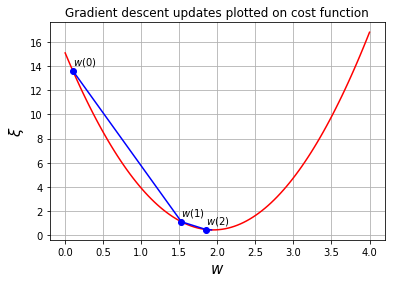

In [12]:
# Plot the first 2 gradient descent updates
plt.plot(ws, cost_ws, 'r-')  # Plot the error curve
# Plot the updates
for i in range(0, len(w_cost)-2):
    w1, c1 = w_cost[i]
    w2, c2 = w_cost[i+1]
    plt.plot(w1, c1, 'bo')
    plt.plot([w1, w2],[c1, c2], 'b-')
    plt.text(w1, c1+0.5, '$w({})$'.format(i)) 
# Show figure
plt.xlabel('$w$', fontsize=15)
plt.ylabel('$\\xi$', fontsize=15)
plt.title('Gradient descent updates plotted on cost function')
plt.grid()
plt.show()

#### 最急降下法による値の更新

上のグラフは最初の2イテレーションのものであり、青の点はk回目のイテレーションにおける重みのパラメータ$w(k)$である。最初の更新の際の勾配$w(0)$は、2回目の更新の勾配$w(1)$よりも大きいので、2回目よりも1回目の更新の方が大きいステップとなる。

10イテレーションを実行し、回帰直線を描く。赤の回帰直線が元の関数f(x)に非常に近いことが分かる。なお、ここではバイアスを考慮していないので、$x=0$のとき$y=0$となる。

In [13]:
w = 0
# Start performing the gradient descent updates
nb_of_iterations = 10  # number of gradient descent updates
for i in range(nb_of_iterations):
    dw = delta_w(w, x, t, learning_rate)  # get the delta w update
    w = w - dw  # update the current weight parameter

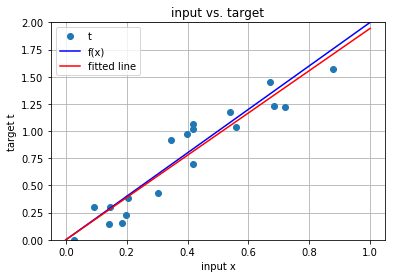

In [14]:
# Plot the fitted line agains the target line
# Plot the target t versus the input x
plt.plot(x, t, 'o', label='t')
# Plot the initial line
plt.plot([0, 1], [f(0), f(1)], 'b-', label='f(x)')
# plot the fitted line
plt.plot([0, 1], [0*w, 1*w], 'r-', label='fitted line')
plt.xlabel('input x')
plt.ylabel('target t')
plt.ylim([0,2])
plt.title('input vs. target')
plt.grid()
plt.legend(loc=2)
plt.show()